In [2]:
import os
import sys
from pathlib import Path
from collections import defaultdict
from multiprocessing import Pool
from Bio import SeqIO

sys.path.append('../src')
from utils import run_cmd

In [37]:
in_path = "/media/NGS/Data_Analysis/20201221_hybrid_and_denovo/Unicycler/Contigs"
out_path = "/media/NGS/Data_Analysis/20201221_hybrid_and_denovo/Unicycler/Mintype"
masking_scheme = "/media/NGS/Data_Analysis/CGE/mintyper/dcmMethylations"
reference = "/media/NGS/Sequence/Listeria_monocytogenes/NC_003210.1_chr.fasta"
f"python MINTyper.py -i_path_assemblies {in_path} -ref {reference} -thread 8 -o {out_path} -masking_scheme {masking_scheme}"

'python MINTyper.py -i_path_assemblies /media/NGS/Data_Analysis/20201221_hybrid_and_denovo/Unicycler/Contigs -ref /media/NGS/Sequence/Listeria_monocytogenes/NC_003210.1_chr.fasta -thread 8 -o /media/NGS/Data_Analysis/20201221_hybrid_and_denovo/Unicycler/Mintype -masking_scheme /media/NGS/Data_Analysis/CGE/mintyper/dcmMethylations'

In [11]:
masking_scheme = '/media/NGS/Data_Analysis/CGE/mintyper/dcmMethylations'
target_dir = '/media/NGS/Data_Analysis/20210803_wgSNP_in_nanopore/MinType/Nanopore_vs_Illumina'
mapping_dir = os.path.join(target_dir, 'DataFiles', '*.fsa')
distmatrix = os.path.join(target_dir, 'distmatrix.txt')
newick_tree = os.path.join(target_dir, 'outtree.newick')

In [12]:
!ccphylo dist -i {mapping_dir} -o {distmatrix} -m {masking_scheme} -mc 1 -nm 0 -r contatnateUserChosenDraftGenome

# 3699013 / 4685848 bases included in distance matrix.


In [17]:
file_1 = '/media/NGS/Nanopore_1/20200925/mintyper/nanopore/DataFiles/R20-0026.fastq.gz_mapping_results.fsa'
file_2 = '/media/NGS/Nanopore_1/20200925/mintyper/nanopore/DataFiles/R20-0127.fastq.gz_mapping_results.fsa'
file_3 = '/media/NGS/Nanopore_1/20200925/mintyper/nanopore/DataFiles/R20-0148.fastq.gz_mapping_results.fsa'
file_4 = '/media/NGS/Nanopore_1/20200925/mintyper/nanopore/DataFiles/R20-0150.fastq.gz_mapping_results.fsa'
distmatrix = '/media/NGS/Data_Analysis/20201221_hybrid_and_denovo/Denovo/Mintype/distmatrix.phy'
!ccphylo dist -i {file_1} {file_2} {file_3} {file_4} -o {distmatrix} -m {masking_scheme} -mc 1 -nm 0 -r contatnateUserChosenDraftGenome

# 2500146 / 2944528 bases included in distance matrix.


In [107]:
!ccphylo tree -i {distmatrix} -o {newick_tree}

In [5]:
import re
from io import StringIO
import pandas as pd

In [54]:
matrix_file = '/media/NGS/Data_Analysis/20201221_hybrid_and_denovo/Raw/Mintype/distmatrix.phy'

In [55]:
data = []
sample_names = []
with open(matrix_file) as f:
    next(f)
    for line in f:
        values = line.strip().split()
        currect_sample, dists = values[0], values[1:]
        for sample_name, dist in zip(sample_names, dists):
            data.append((currect_sample, sample_name, dist))
            data.append((sample_name, currect_sample, dist))
        data.append((currect_sample, currect_sample, 0))
        sample_names.append(currect_sample)

In [56]:
# prog = re.compile('^R[0-9]+-[0-9]+|^(\w+)')
prog = re.compile('^R[0-9]+-[0-9]+#[a-z]+')

In [57]:
df = pd.DataFrame(data)
df = df.pivot(index=0, columns=1, values=2).astype(int)

In [58]:
df.index = list(map(lambda x: prog.search(x).group(0), df.index))
df.columns = list(map(lambda x: prog.search(x).group(0), df.columns))
df

,R20-0026#illumina,R20-0026#nanopore,R20-0127#illumina,R20-0127#nanopore,R20-0148#illumina,R20-0148#nanopore,R20-0150#illumina,R20-0150#nanopore
R20-0026#illumina,0,79,84774,84544,84775,84545,84774,84544
R20-0026#nanopore,79,0,84751,84489,84752,84490,84751,84489
R20-0127#illumina,84774,84751,0,385,11,396,18,400
R20-0127#nanopore,84544,84489,385,0,396,11,400,16
R20-0148#illumina,84775,84752,11,396,0,385,19,401
R20-0148#nanopore,84545,84490,396,11,385,0,401,17
R20-0150#illumina,84774,84751,18,400,19,401,0,384
R20-0150#nanopore,84544,84489,400,16,401,17,384,0


In [26]:
from tree import Dendrogram

In [67]:
dendrogram = Dendrogram(df)
dendrogram(show_node_info=True, xlim=500)

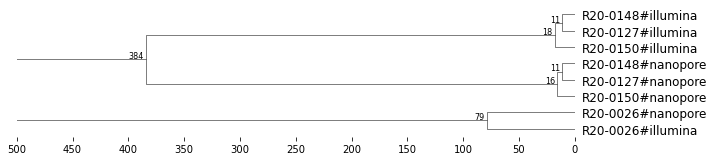

In [68]:
dendrogram.show_figure

In [69]:
dendrogram.savefig('/media/NGS/Data_Analysis/20201221_hybrid_and_denovo/Raw/Mintype/partial_tree.pdf')